In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifierCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
train_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_Train_with_TRUE_85500inds.feather")
print(train_df.columns)
print(train_df.shape)
print("Number of inds in train:", train_df.shape[0]/29)
test_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_Test_with_TRUE_9699inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds in test:", test_df.shape[0]/29)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=190)
(2479500, 190)
Number of inds in train: 85500.0
Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=190)
(281271, 190)
Number of inds in test: 9699.0


In [4]:
# set length to 20
train_df = copy.deepcopy(train_df[train_df['QUARTER']>8])
test_df = copy.deepcopy(test_df[test_df['QUARTER']>8])
print(train_df.shape[0]/20)
print(test_df.shape[0]/20)
# remove true values
# remove QUARTER
train_df = train_df.drop(['QUARTER'], axis=1)
test_df = test_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(train_df.iloc[:, :-7].values)
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)
print(train_v.shape)
print(train_v.shape[0]/20)
print(test_v.shape)
print(test_v.shape[0]/20)

85500.0
9699.0
(1710000, 182)
85500.0
(193980, 182)
9699.0


In [5]:
print('LL_PDC:', train_df.columns.get_loc('LL_PDC'))

LL_PDC: 28


In [15]:
def setup_xy_last_quarter(time_series_v):
    num_of_inds = time_series_v.shape[0]//20
    num_of_features = time_series_v.shape[1]
    
    x_ = np.empty((num_of_inds, num_of_features))
    y_ = []
    for i in range(num_of_inds):
        ind_v = copy.deepcopy(time_series_v[(i*20):((i+1)*20), :])
        x_[i, :] = ind_v[15, :]
        if sum(ind_v[16:, 28])/4 >= 80:
            y_.append(1)
        else:
            y_.append(0)
    return x_, np.array(y_)

In [16]:
def setup_xy_aggregated(time_series_v, obs_steps):
    num_of_inds = time_series_v.shape[0]//20
    num_of_features = time_series_v.shape[1]
    
    x_ = np.empty((num_of_inds, num_of_features))
    y_ = []
    for i in range(num_of_inds):
        ind_v = copy.deepcopy(time_series_v[(i*20):((i+1)*20), :])
        x_[i, 0:9] = ind_v[15, 0:9]
        x_[i, 9:169] = np.sum(ind_v[(16-obs_steps):16, 9:169], axis=0)/obs_steps
        x_[i, 169:182] = ind_v[15, 169:182]
        if sum(ind_v[16:, 28])/4 >= 80:
            y_.append(1)
        else:
            y_.append(0)
    return x_, np.array(y_)

In [17]:
def setup_xy(time_series_v, obs_steps):
    x_ = []
    y_ = []
    num_of_inds = time_series_v.shape[0]//20
    num_of_features = time_series_v.shape[1]
    print("Number of inds:", num_of_inds)
    print("Number of features:", num_of_features)
    for i in range(num_of_inds):
        ind_v = time_series_v[(i*20):((i+1)*20), :]
        ind_x = ind_v[(16-obs_steps):16, :] # at most len 16
        ind_flat_x = []
        for j in range(len(ind_x)):
            if j == 0:
                ind_flat_x.extend(ind_x[j, :])
            else:
                ind_flat_x.extend(ind_x[j, 1:])
        x_.append(np.array(ind_flat_x))
        if sum(ind_v[16:20, 28])/4 >= 80:
            y_.append(1)
        else:
            y_.append(0)
    return np.array(x_), np.array(y_)

In [53]:
#x_train, y_train = setup_xy(train_v, 4)
#x_test, y_test = setup_xy(test_v, 4)

#x_train, y_train = setup_xy_aggregated(train_v, 4)
#x_test, y_test = setup_xy_aggregated(test_v, 4)

x_train, y_train = setup_xy_last_quarter(train_v)
x_test, y_test = setup_xy_last_quarter(test_v)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(85500, 182)
(85500,)
(9699, 182)
(9699,)


(85500,)


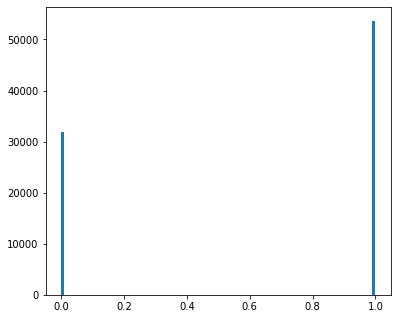

In [54]:
pyplot.rcParams.update({'font.size': 10})
pyplot.figure(figsize=(8,5))
pyplot.subplot(111)
pyplot.hist(y_train[:], bins=100)

pyplot.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.7, hspace=0.4, wspace=0.2)
pyplot.show()

In [55]:
num_of_inds = x_train.shape[0]
num_per_fold = num_of_inds//10
print("Number of inds:", num_of_inds)
print("Number per fold:", num_per_fold)

rmse_lstm_list = []
rmse_naive_list = []


start_time = time.time()
for f in range(1):
    #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_lr = np.append(train2_x, train1_x, axis=0) #new obj
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_lr = np.append(train2_y, train1_y, axis=0)
    print("train_x_lr:", train_x_lr.shape)
    print("train_y_lr:", train_y_lr.shape)
    
    # remove data used for 
    # validation set
    val_num = int(np.ceil(train_x_lr.shape[0]/10))
    print("val num:", val_num)
    train_x = train_x_lr[:-val_num, :]
    print("Train x shape:", train_x.shape)
    train_y = train_y_lr[:-val_num]
    print("Train y shape:", train_y.shape)
    
    rcv = RidgeClassifierCV(alphas=[1e-6, 1e-5, 1e-4, 
                                    1e-3, 1e-2, 1e-1,
                                    1.0, 10.0], 
                            normalize=True,
                            store_cv_values=True).fit(train_x, train_y)

    print("Prediction using RidgeCV")
    a = rcv.alpha_
    print("Alpha:", a)
    print("R^2:", rcv.score(train_x, train_y))
    ########################
    # Predict on test set
    ########################
    print("Test x shape:", x_test.shape)
    print("Test y shape:", y_test.shape)
    
    test_yhat = rcv.predict(x_test)
    lr_probs = rcv.decision_function(x_test)
    print('lr_probs shape:', lr_probs.shape)
    print(np.array([lr_probs[: ]]).T.shape)
    
print("Entire process took: ", time.time() - start_time)

Number of inds: 85500
Number per fold: 8550
train_x_lr: (85500, 182)
train_y_lr: (85500,)
val num: 8550
Train x shape: (76950, 182)
Train y shape: (76950,)
Prediction using RidgeCV
Alpha: 0.001
R^2: 0.85364522417154
Test x shape: (9699, 182)
Test y shape: (9699,)
lr_probs shape: (9699,)
(9699, 1)
Entire process took:  0.9914746284484863


In [56]:
print(test_yhat[:10])
print(lr_probs[:10])
print(y_test[:10])

[1 0 1 1 1 0 1 1 0 1]
[ 0.71873034 -1.23275249  0.93786788  0.72927474  0.70331616 -0.45656877
  0.58998052  0.97119242 -1.01486359  0.55647456]
[1 0 1 1 0 0 1 1 0 1]


In [57]:
lr_probs_df = pd.DataFrame(lr_probs)
lr_probs_df.columns = ['LL_COVERED']
print(lr_probs_df.shape)
#"/home/whsu014/data/Post_PREDICT_PDC_16to4_RC_yhat.feather"
#Post_PREDICT_PDC_4to4_RC_aggregated_yhat.feather
#Post_PREDICT_PDC_RC_last_quarter_yhat.feather
feather.write_dataframe(lr_probs_df, "/home/whsu014/data/Post_PREDICT_PDC_RC_last_quarter_yhat.feather")

(9699, 1)
